In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)



/usr/bin/python


In [2]:
ticker = params.ticker

month_to_plot = params.date_to_test # just used if date_to_check = None

date_to_check = params.date_to_check 

[main] Found existing base CSV: dfs training/GOOGL_base.csv


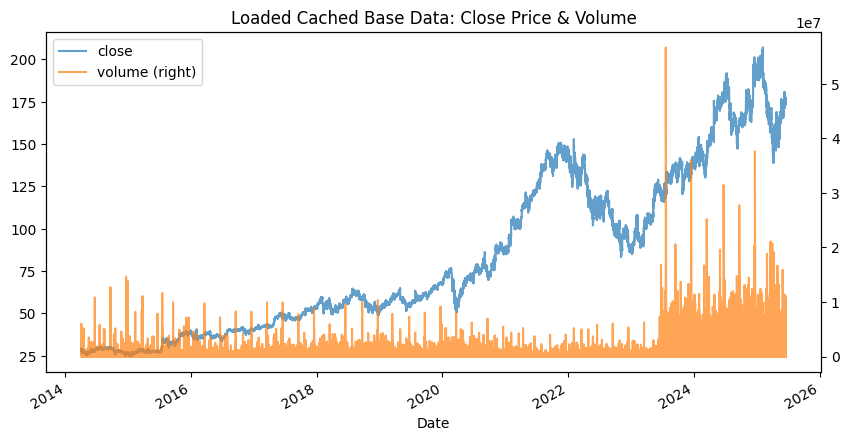

open      high      low     close     volume  \
2014-04-03 08:30:00   28.650   28.6500   28.650   28.6500     2000.0   
2014-04-03 08:31:00   28.650   28.6500   28.650   28.6500     2000.0   
2014-04-03 08:32:00   28.650   28.6500   28.650   28.6500     2000.0   
2014-04-03 08:33:00   28.650   28.6500   28.650   28.6500     2000.0   
2014-04-03 08:34:00   28.650   28.6500   28.650   28.6500     2000.0   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                            ask         bid  
2014-04-03 08:30:00   28.658595   28.641405  
2014-04-03 08:31:00   28.658595   28.641405  
2014-04-03 08:32:00   28.658595   28.641405  
2014-04-03 08:33:00   28.658595   28.641405  
2014-04-03 08:34:00   28.658595   28.641405  
...                         ...         ...  
2025-06-18 20:56:00  173.617100  173.512900  
2025-06-18 20:57:00  173.432000  173.328000  
2025-06-18 20:58:00  173.362000  173.258000  
2025-06-18 20:59:00  173.332000  173.228000  
2025-06-18 21:00:00  173.661800  173.557600  

[2117820 rows x 7 columns]

In [3]:
base_csv = os.path.join(params.save_path, f"{ticker}_base.csv")

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
global_ref  = trades.compute_global_ref_profit(df = df)
global_ref # reference median used to scale the signal

0.20749999999998892

In [5]:

def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return
            
    print("\n Running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df, 
                                         col_signal='signal_smooth',
                                         col_action='signal_action',
                                         ref_profit=global_ref,
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal_raw',
        col_signal2='signal_smooth',
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [6]:
def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume", "bid","ask",
            "StrategyEarning","EarningDiff", "signal_raw", "signal_smooth", "signal_action"
        ]

    if date_to_check:
        if len(date_to_check) == 7:
            # -------------------------------------------------------------------------
            # # Month mode: 'YYYY-MM'
            # -------------------------------------------------------------------------
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            dates_days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )

            performance_list = []
            daily_frames     = []
            
            for date_day in sorted(dates_days.astype(str)):
                res = process_single_day(date_day, buy_threshold)
                if res is None:
                    continue
    
                df_day, perf_day = res
                daily_frames.append(df_day)       # collect the day’s DF
                performance_list.append(perf_day) # collect its stats
    
            if not daily_frames:
                print("No valid days in this month.")
                return
    
            # build the month‐DF from exactly those df_day’s
            df_month = pd.concat(daily_frames).sort_index()
            # print monthly performance summary
            monthly_summary = plots.aggregate_performance(performance_list, df_month)
            pprint(monthly_summary)

            return df_month
            
        else:
            # -------------------------------------------------------------------------
            # Single-day mode: 'YYYY-MM-DD'
            # -------------------------------------------------------------------------
            return process_single_day(date_to_check, buy_threshold)

    # -------------------------------------------------------------------------
    # Full mode: Processing all days and saving dataframe
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode")
      
    print("\n•Running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df,
        col_signal='signal_smooth',
        col_action='signal_action',
        ref_profit=global_ref,
        day_to_check=None
    )

    print("\n•Merging, concatenating all days, and calculating test performances …")
    daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all          = pd.concat(daily_frames).sort_index()
    performance_all = [res[2] for res in full_sim_results.values()]
    all_summary = plots.aggregate_performance(performance_all, df_all)
    days_all = df_all.index.normalize().unique()
    pprint(all_summary)

    # prepare the performances summary just for the test days
    cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
    df_test = df_all[ df_all.index.normalize().isin(test_days) ]
    performance_test = [perf
                        for day, (_,_,perf) in full_sim_results.items()
                        if pd.Timestamp(day).normalize() in test_days]
    test_summary = plots.aggregate_performance(performance_test, df_test)
    pprint(test_summary)
    

    print("\n•Saving CSV …")
    out_path = f"dfs training/{ticker}_ready.csv"
    df_all.to_csv(out_path)
    print(f"Saved to {out_path}")

    return df_all




Month mode: processing 2025-04

=== Processing trading day 2025-04-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


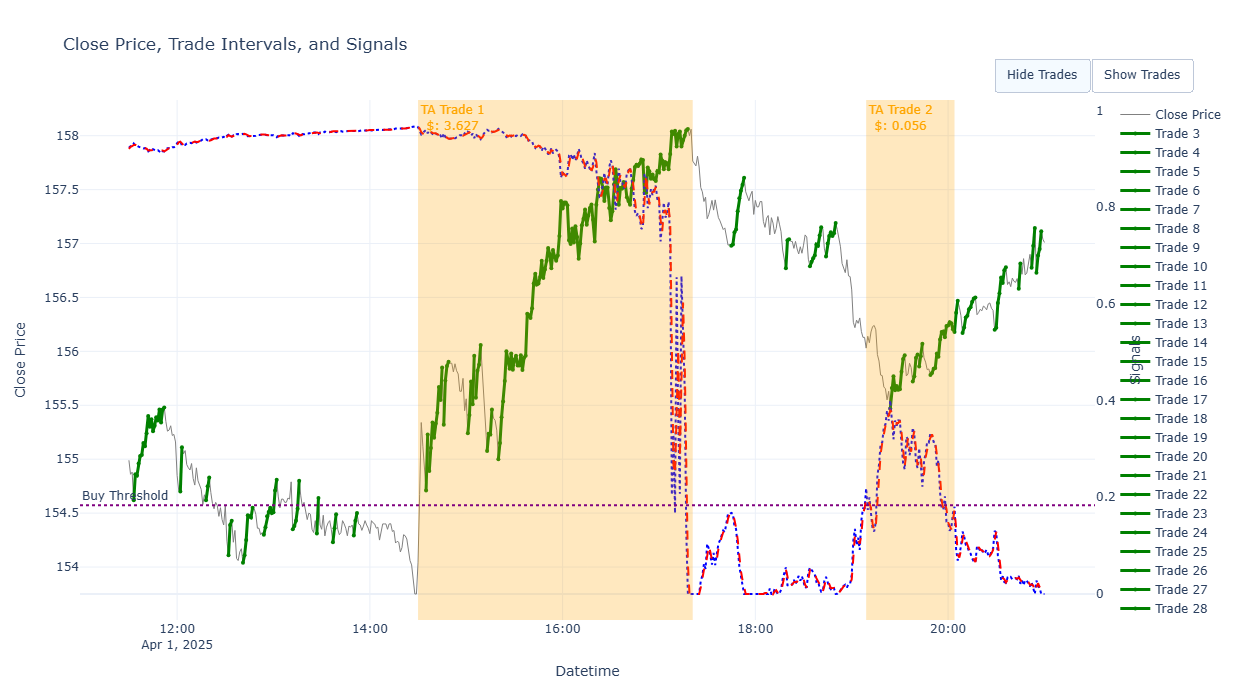


=== Performance for 2025-04-01 00:00:00 ===
Strategy Return ($): 3.683
Buy & Hold Return ($): 2.902
Trades Returns ($): [3.627, 0.056]

=== Processing trading day 2025-04-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


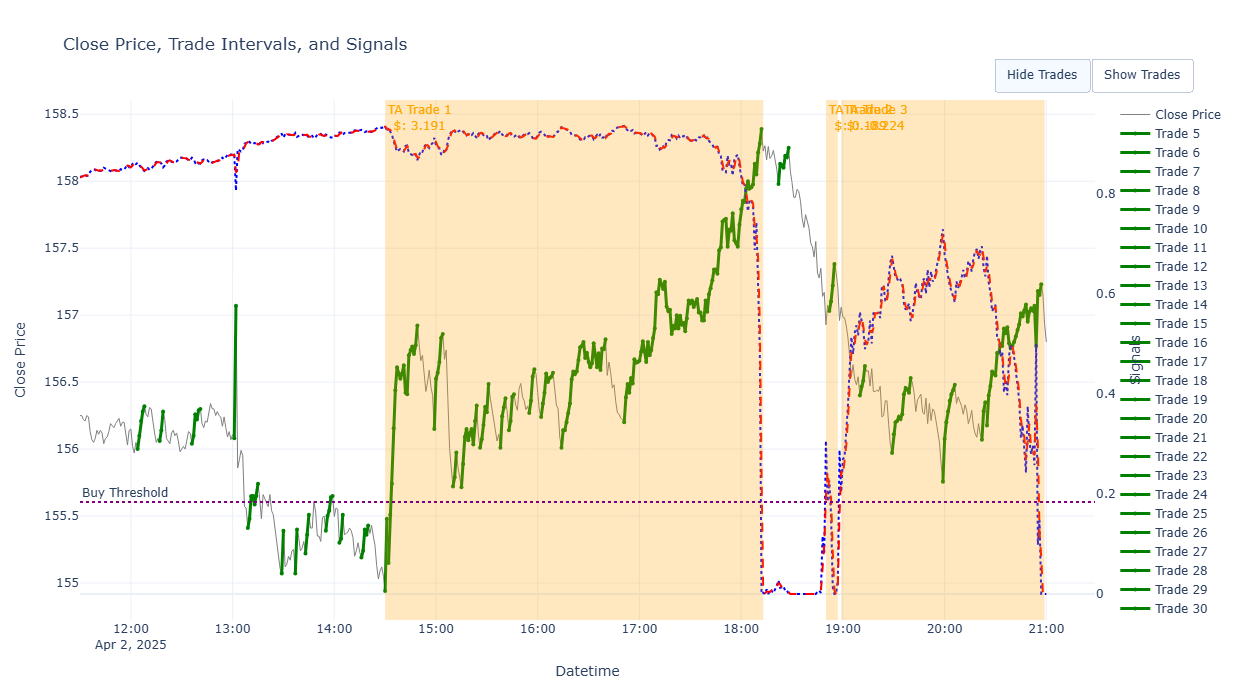


=== Performance for 2025-04-02 00:00:00 ===
Strategy Return ($): 3.156
Buy & Hold Return ($): 1.896
Trades Returns ($): [3.191, 0.189, -0.224]

=== Processing trading day 2025-04-03 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


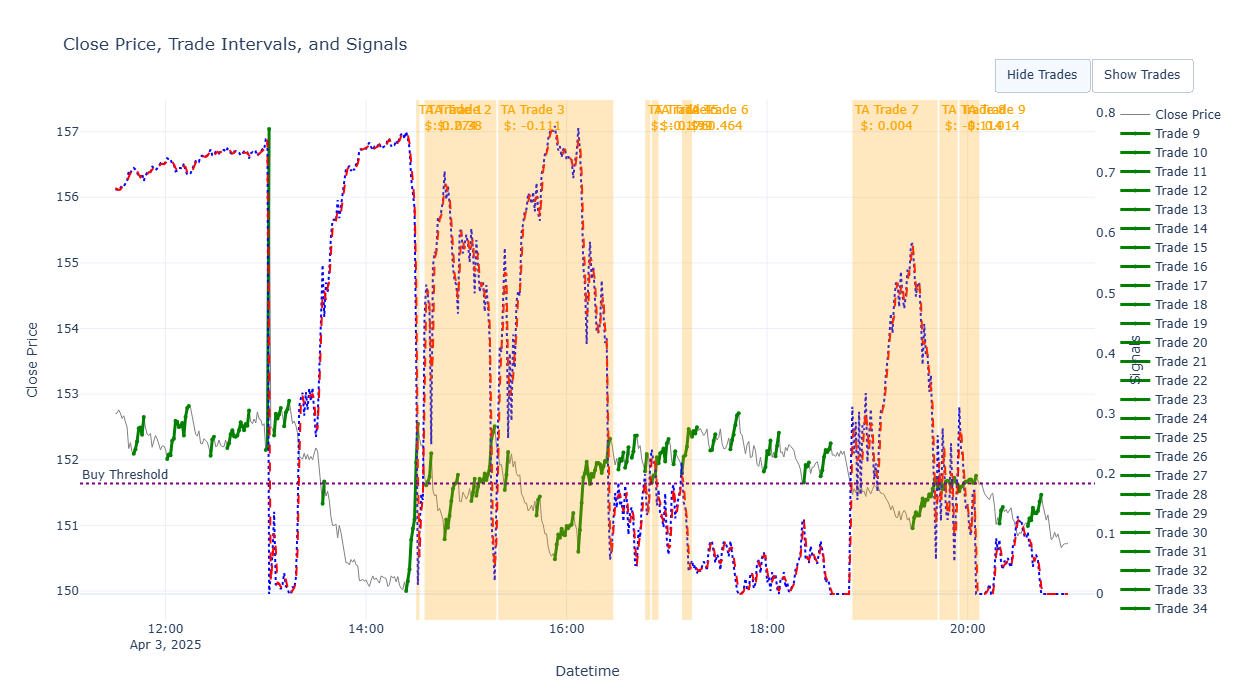


=== Performance for 2025-04-03 00:00:00 ===
Strategy Return ($): 0.934
Buy & Hold Return ($): -1.331
Trades Returns ($): [0.274, 0.38, -0.111, -0.176, 0.199, 0.464, 0.004, -0.114, 0.014]

=== Processing trading day 2025-04-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


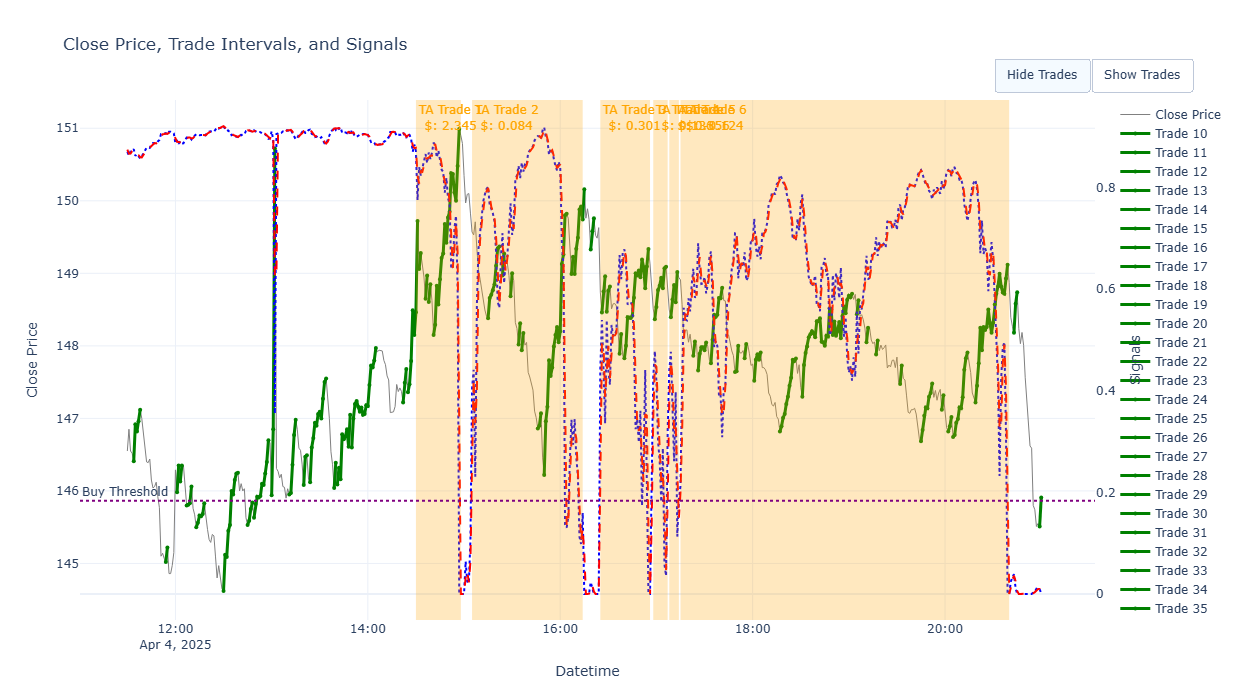


=== Performance for 2025-04-04 00:00:00 ===
Strategy Return ($): 3.097
Buy & Hold Return ($): -3.043
Trades Returns ($): [2.345, 0.084, 0.301, 0.136, 0.356, -0.124]

=== Processing trading day 2025-04-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


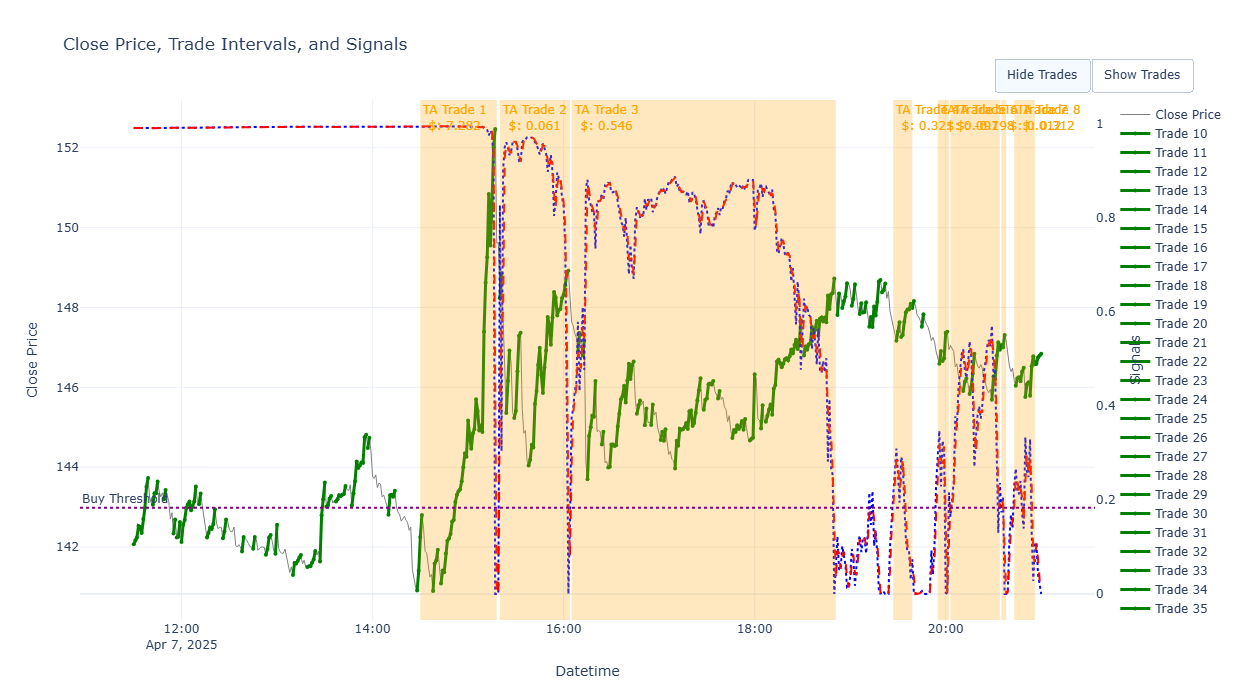


=== Performance for 2025-04-07 00:00:00 ===
Strategy Return ($): 8.434
Buy & Hold Return ($): 4.463
Trades Returns ($): [7.282, 0.061, 0.546, 0.321, 0.097, -0.198, 0.012, 0.312]

=== Processing trading day 2025-04-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


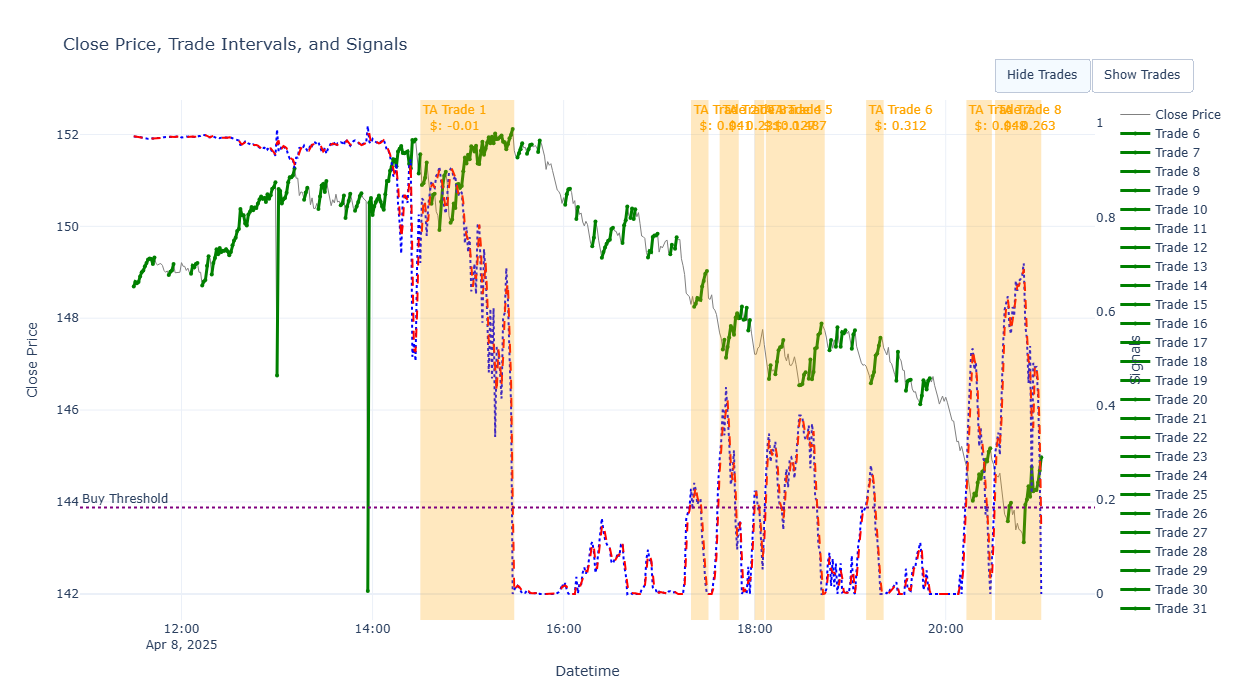


=== Performance for 2025-04-08 00:00:00 ===
Strategy Return ($): 1.209
Buy & Hold Return ($): -6.978
Trades Returns ($): [-0.01, 0.041, 0.231, 0.127, 0.487, 0.312, 0.048, 0.263]

=== Processing trading day 2025-04-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


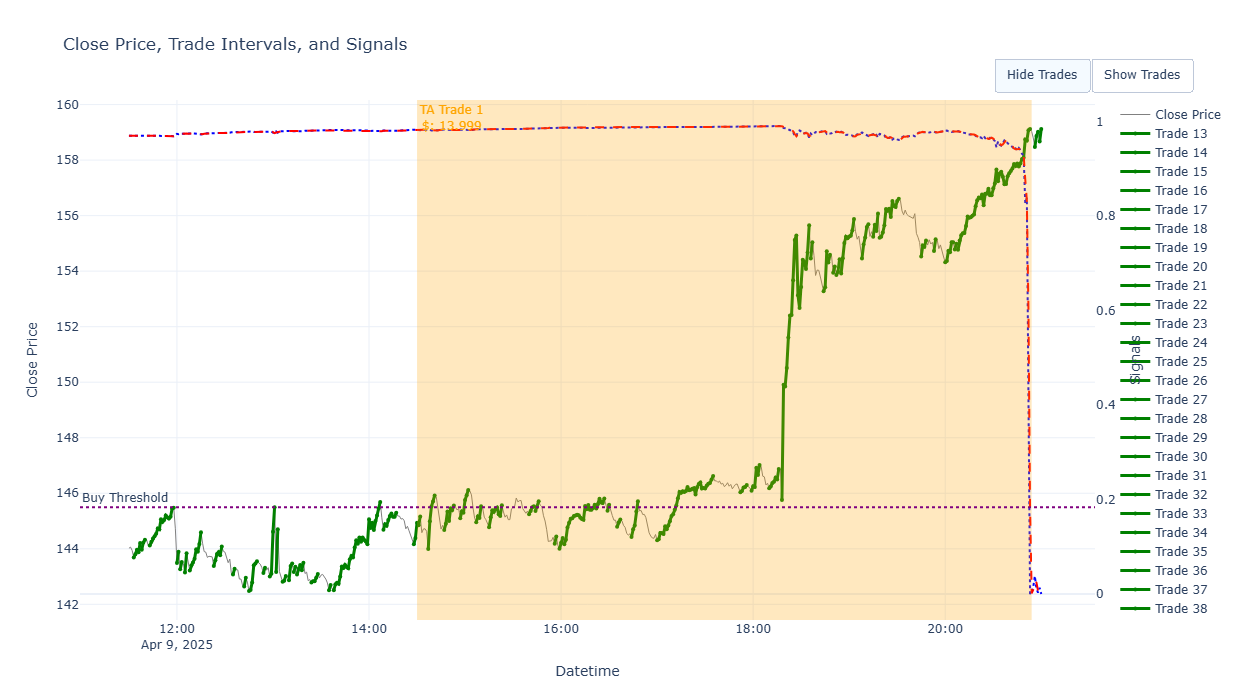


=== Performance for 2025-04-09 00:00:00 ===
Strategy Return ($): 13.999
Buy & Hold Return ($): 13.639
Trades Returns ($): [13.999]

=== Processing trading day 2025-04-10 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


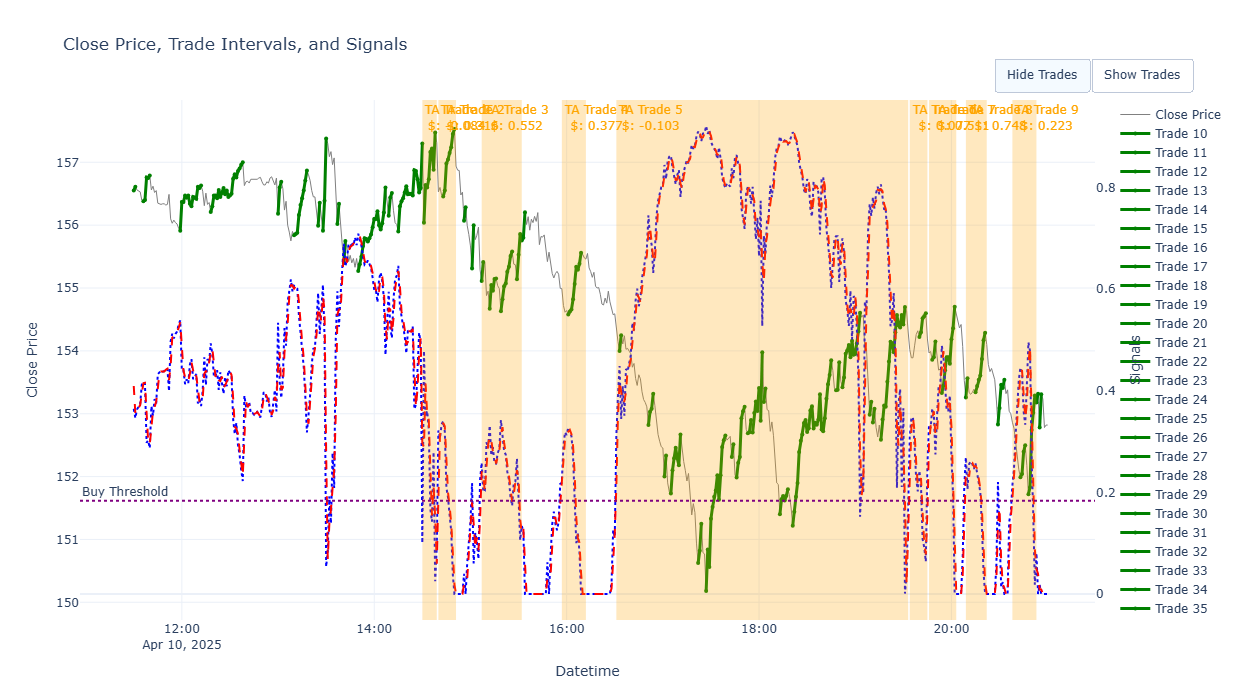


=== Performance for 2025-04-10 00:00:00 ===
Strategy Return ($): 2.617
Buy & Hold Return ($): -4.573
Trades Returns ($): [-0.084, 0.316, 0.552, 0.377, -0.103, 0.077, 0.511, 0.748, 0.223]

=== Processing trading day 2025-04-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


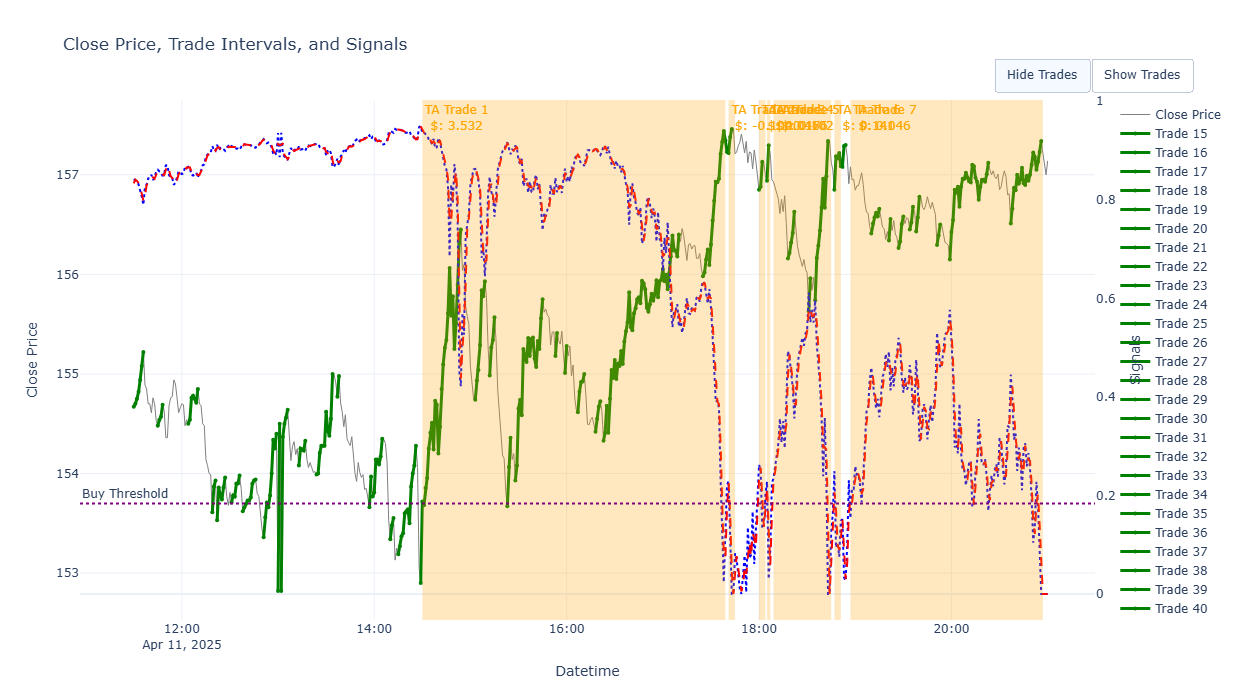


=== Performance for 2025-04-11 00:00:00 ===
Strategy Return ($): 3.937
Buy & Hold Return ($): 3.187
Trades Returns ($): [3.532, -0.104, 0.046, 0.176, 0.102, 0.141, 0.046]

=== Processing trading day 2025-04-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


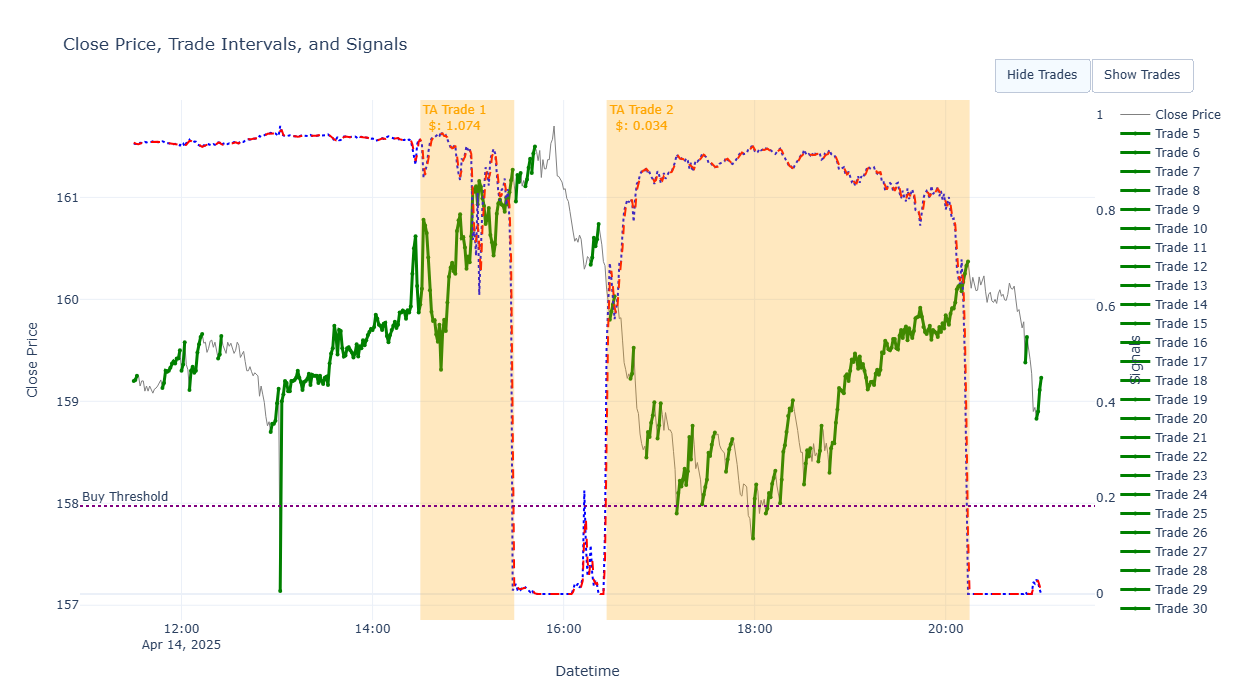


=== Performance for 2025-04-14 00:00:00 ===
Strategy Return ($): 1.108
Buy & Hold Return ($): -0.936
Trades Returns ($): [1.074, 0.034]

=== Processing trading day 2025-04-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


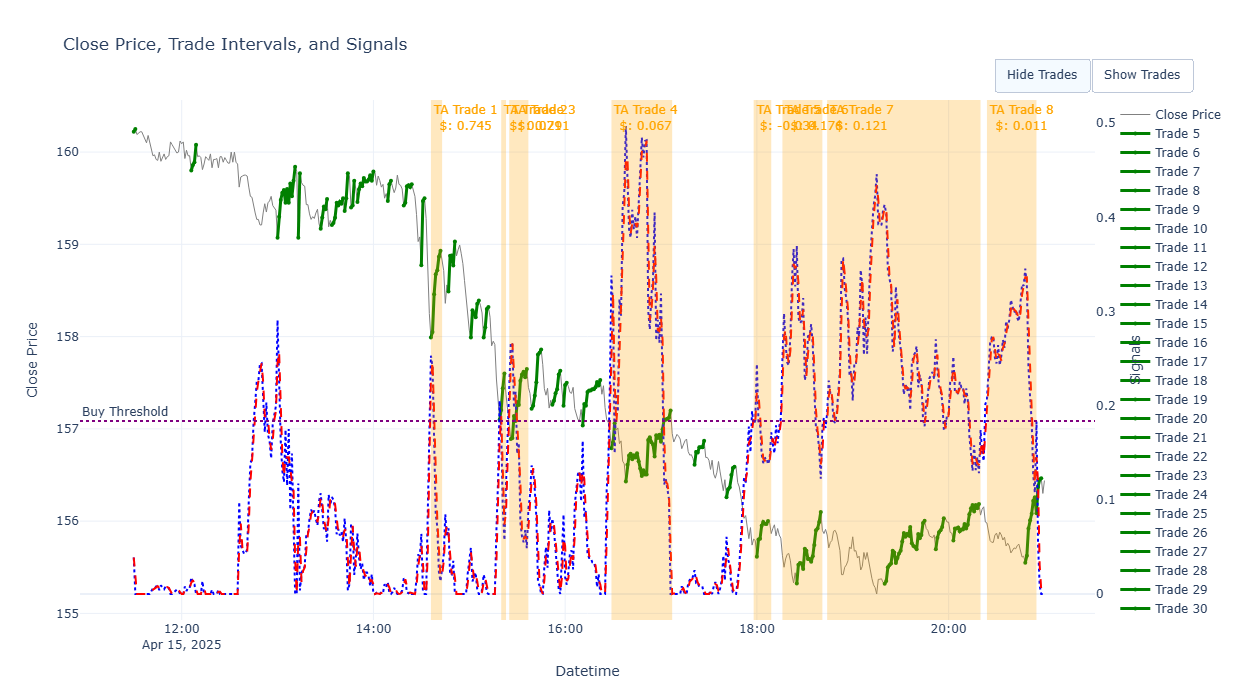


=== Performance for 2025-04-15 00:00:00 ===
Strategy Return ($): 1.449
Buy & Hold Return ($): -2.568
Trades Returns ($): [0.745, 0.071, 0.291, 0.067, -0.034, 0.176, 0.121, 0.011]

=== Processing trading day 2025-04-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


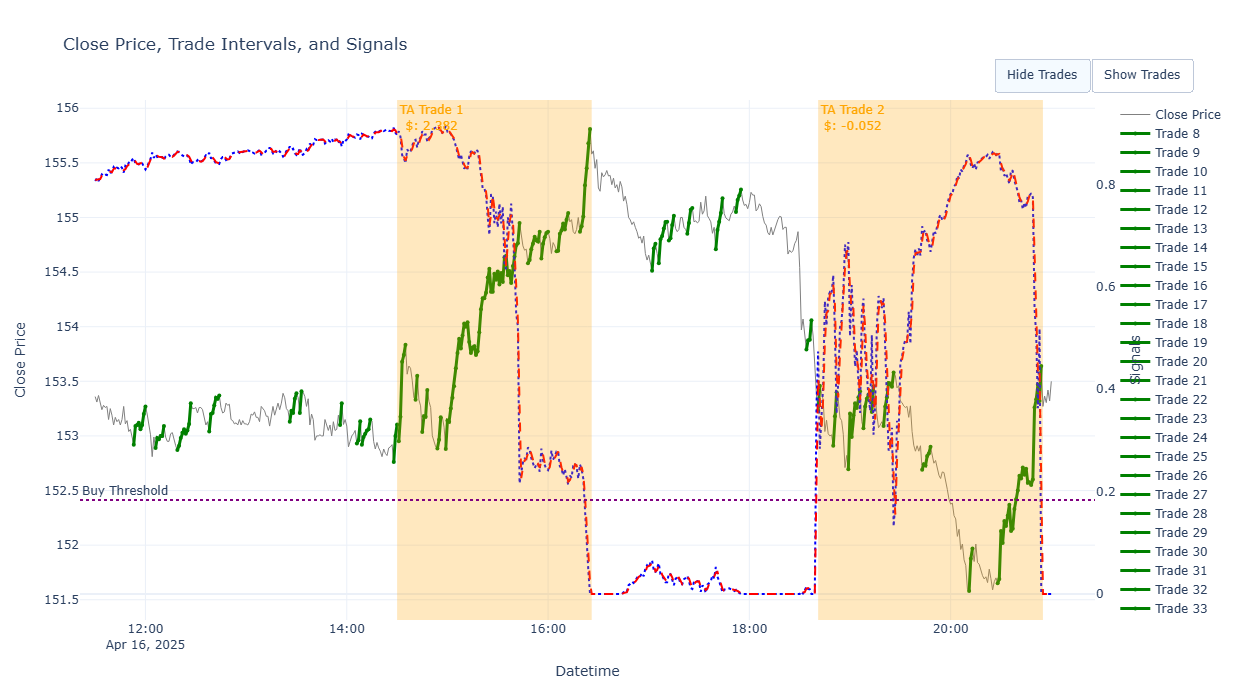


=== Performance for 2025-04-16 00:00:00 ===
Strategy Return ($): 2.33
Buy & Hold Return ($): 0.123
Trades Returns ($): [2.382, -0.052]

=== Processing trading day 2025-04-17 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


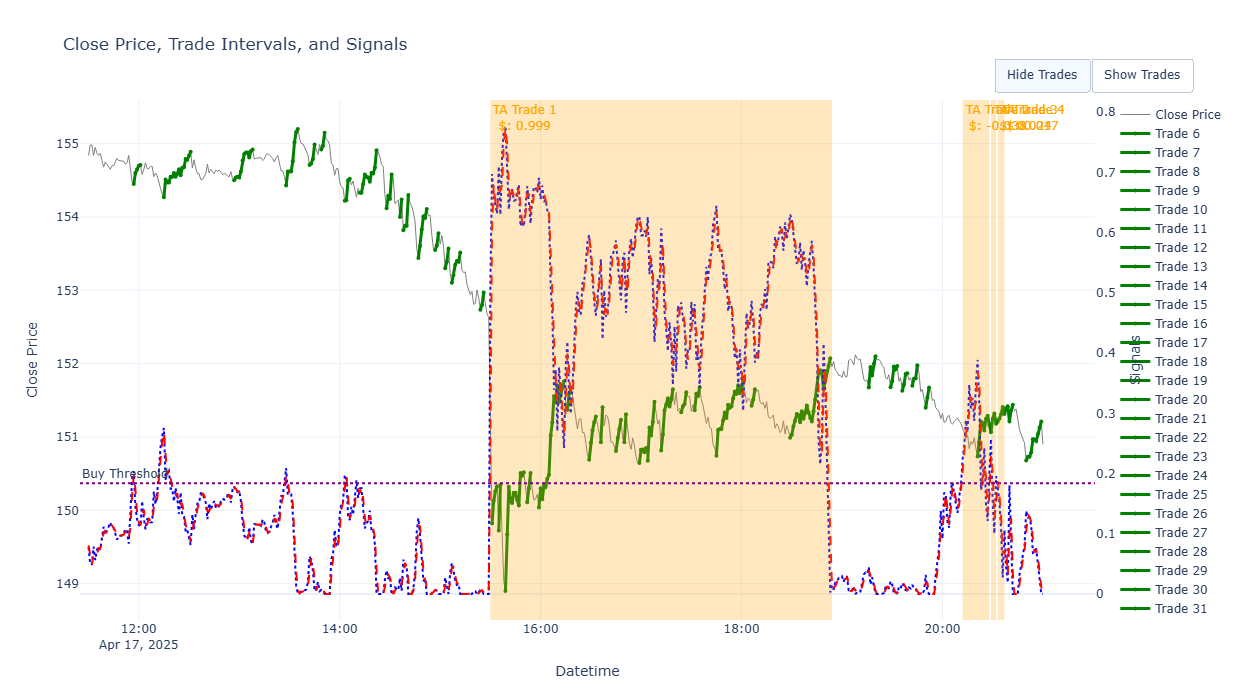


=== Performance for 2025-04-17 00:00:00 ===
Strategy Return ($): 1.002
Buy & Hold Return ($): -3.127
Trades Returns ($): [0.999, -0.038, 0.024, 0.017]

=== Processing trading day 2025-04-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


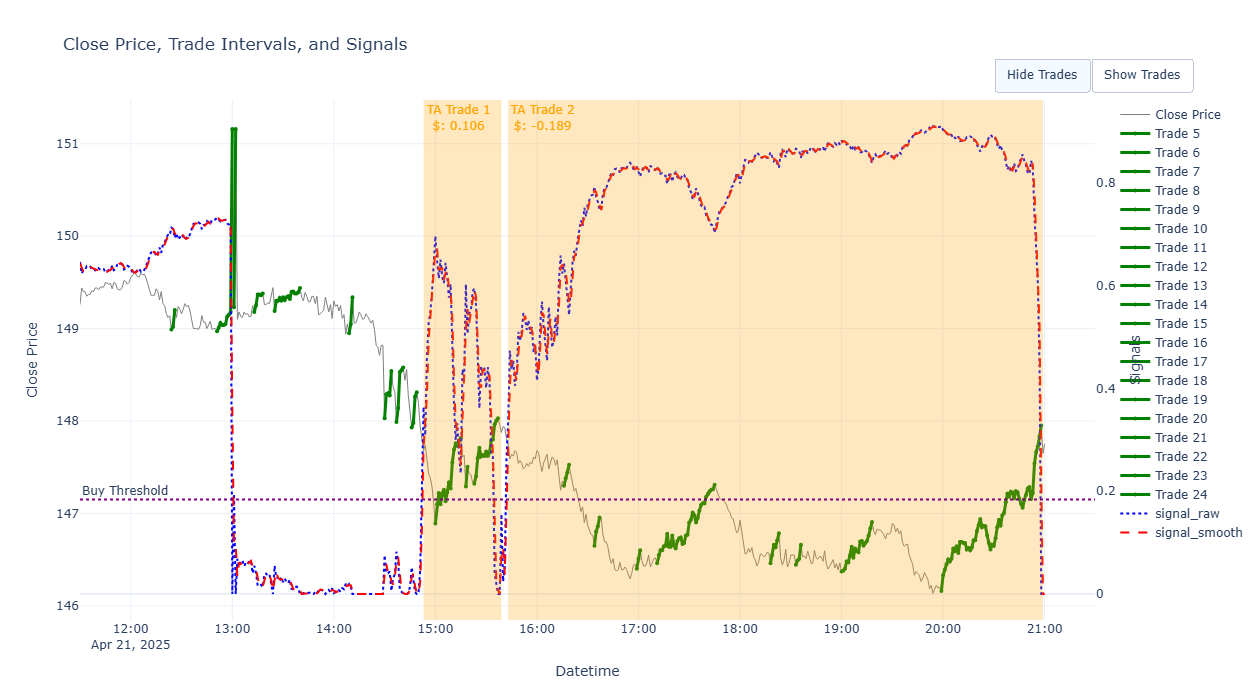


=== Performance for 2025-04-21 00:00:00 ===
Strategy Return ($): -0.082
Buy & Hold Return ($): -0.469
Trades Returns ($): [0.106, -0.189]

=== Processing trading day 2025-04-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


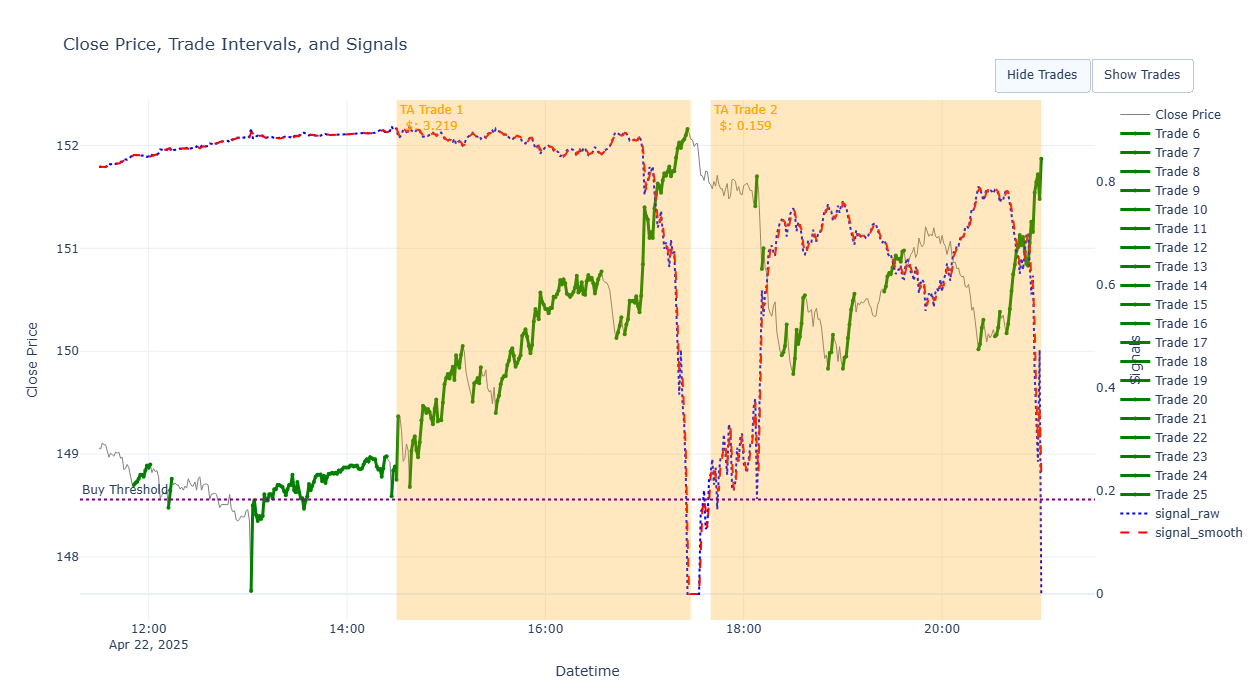


=== Performance for 2025-04-22 00:00:00 ===
Strategy Return ($): 2.988
Buy & Hold Return ($): 2.639
Trades Returns ($): [3.219, 0.159]

=== Processing trading day 2025-04-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


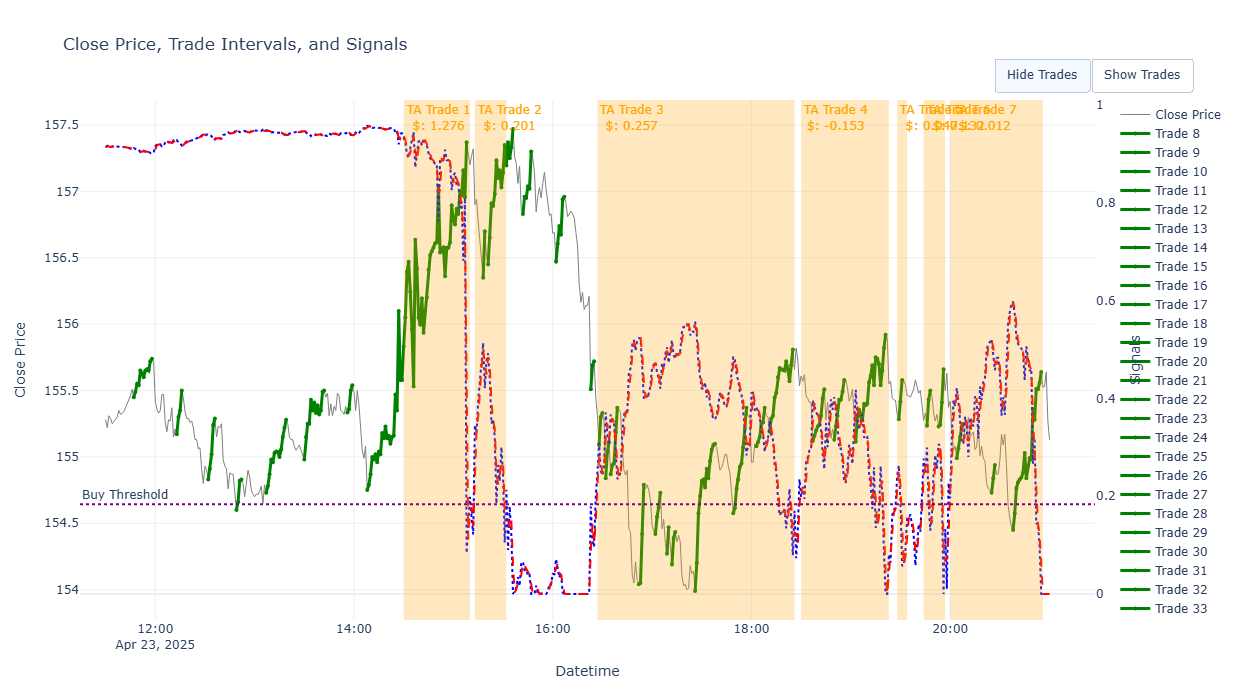


=== Performance for 2025-04-23 00:00:00 ===
Strategy Return ($): 1.77
Buy & Hold Return ($): -0.653
Trades Returns ($): [1.276, 0.201, 0.257, -0.153, 0.047, 0.132, 0.012]

=== Processing trading day 2025-04-24 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


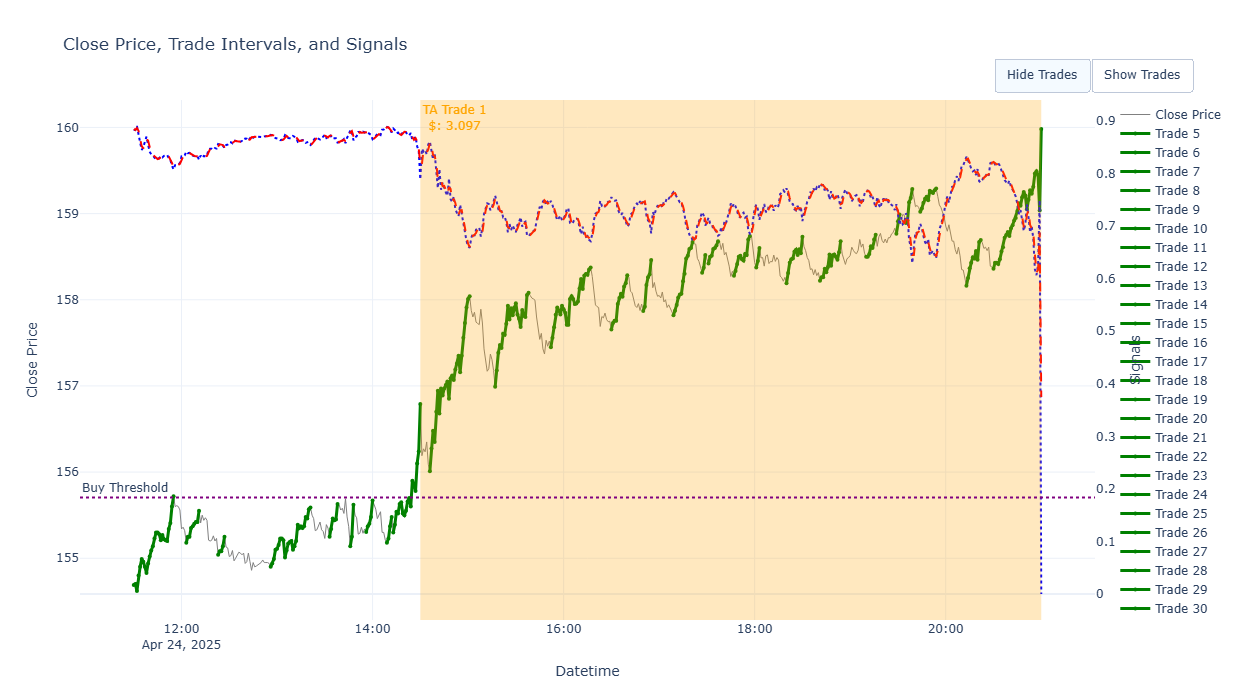


=== Performance for 2025-04-24 00:00:00 ===
Strategy Return ($): 2.15
Buy & Hold Return ($): 2.15
Trades Returns ($): [3.097]

=== Processing trading day 2025-04-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


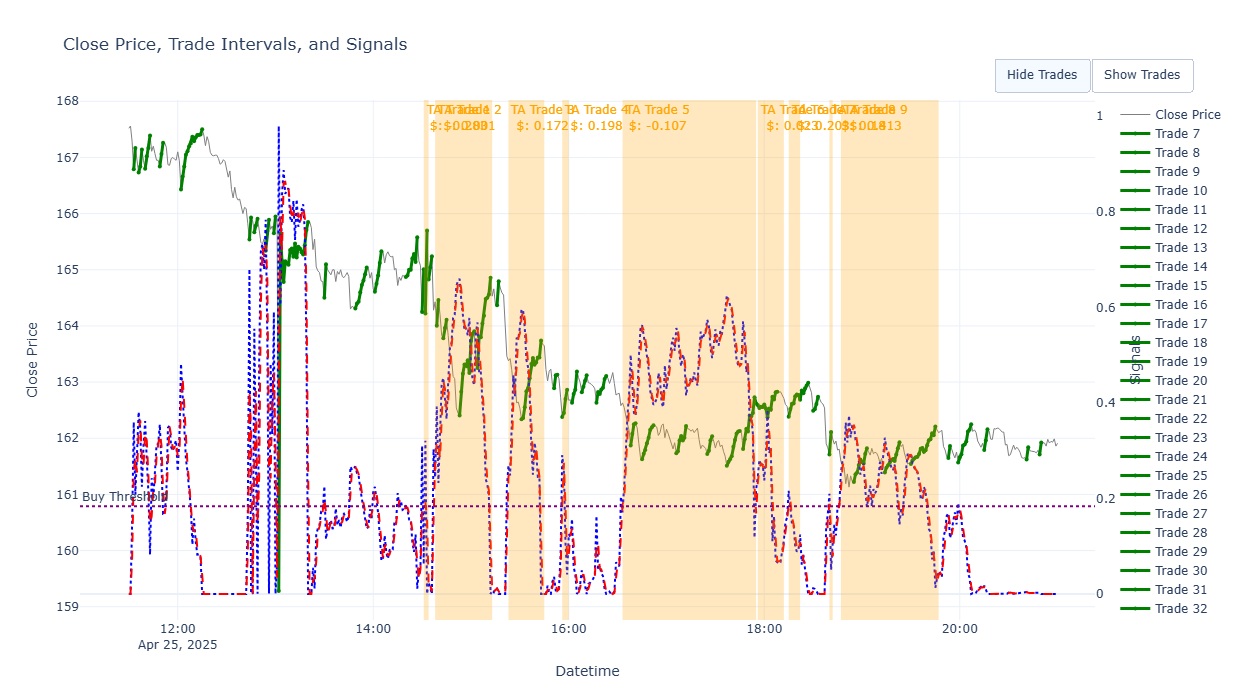


=== Performance for 2025-04-25 00:00:00 ===
Strategy Return ($): 0.798
Buy & Hold Return ($): -2.485
Trades Returns ($): [-0.283, 0.001, 0.172, 0.198, -0.107, 0.023, 0.203, 0.18, 0.413]

=== Processing trading day 2025-04-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


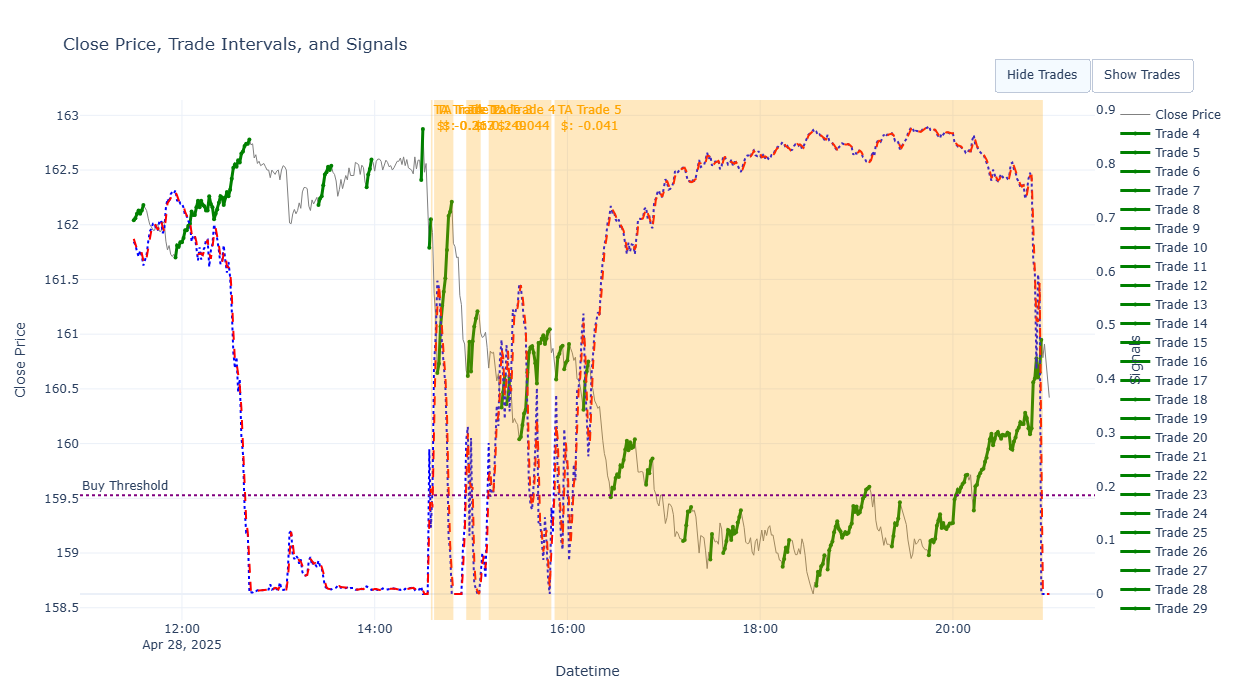


=== Performance for 2025-04-28 00:00:00 ===
Strategy Return ($): 0.397
Buy & Hold Return ($): -2.362
Trades Returns ($): [-0.217, 0.363, 0.249, 0.044, -0.041]

=== Processing trading day 2025-04-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


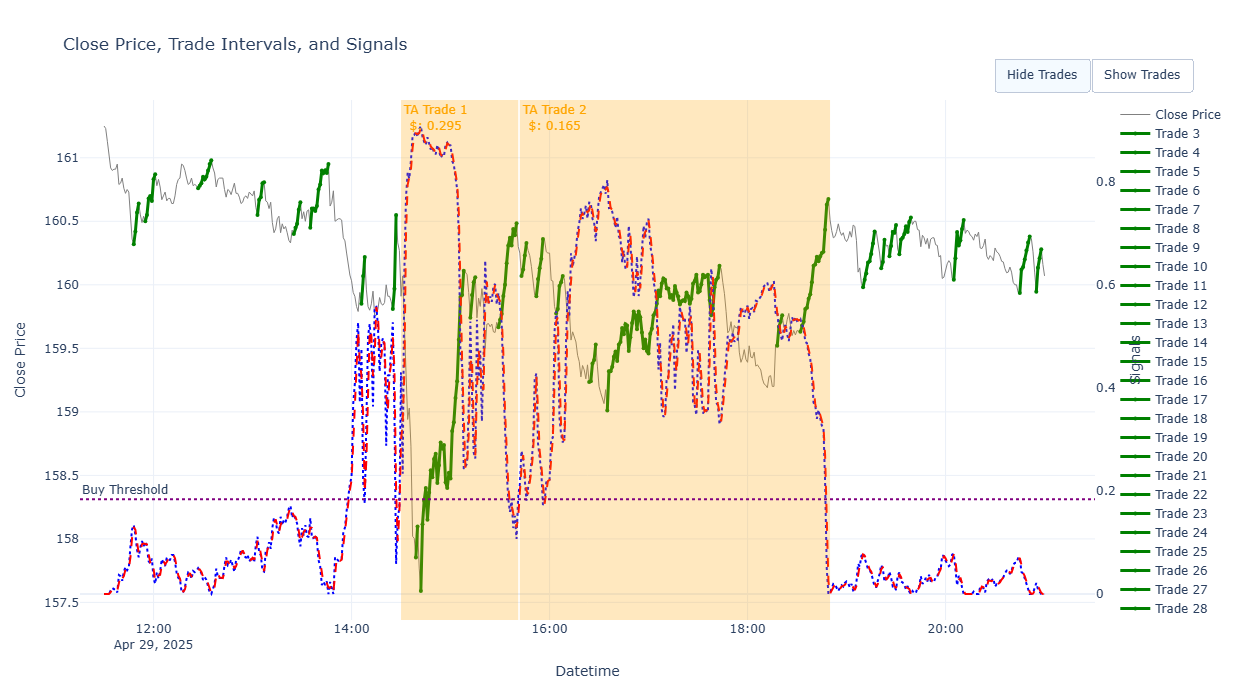


=== Performance for 2025-04-29 00:00:00 ===
Strategy Return ($): 0.46
Buy & Hold Return ($): 0.154
Trades Returns ($): [0.295, 0.165]

=== Processing trading day 2025-04-30 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


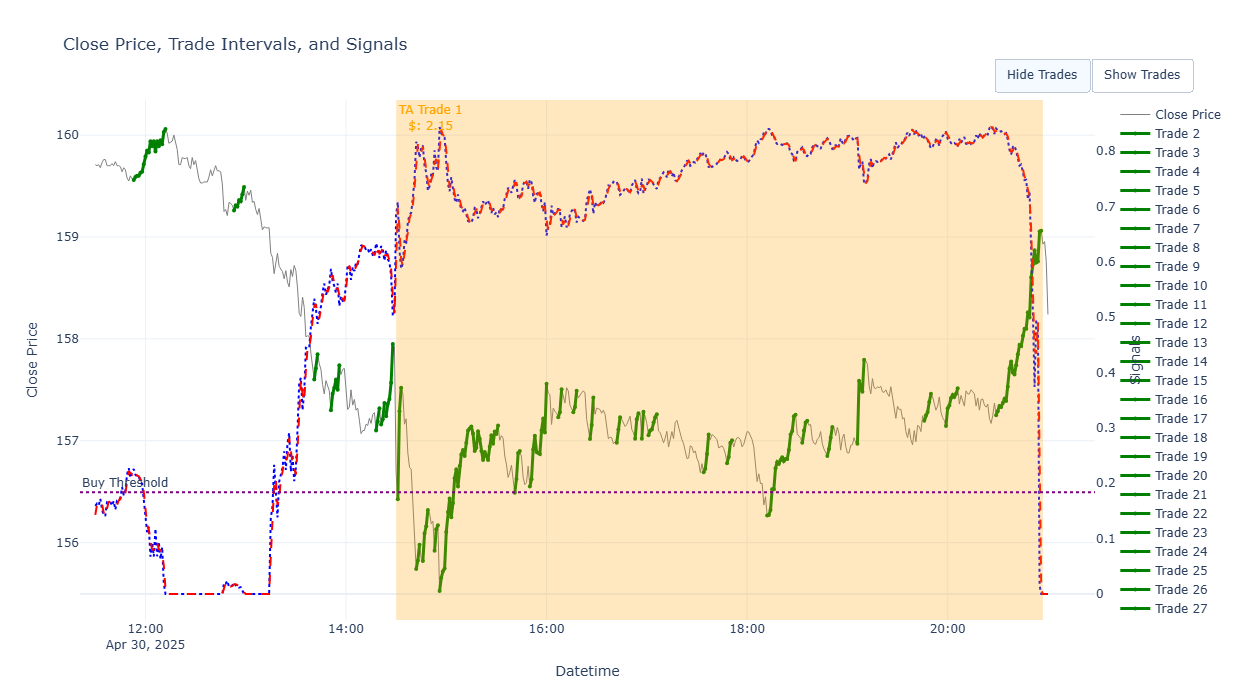


=== Performance for 2025-04-30 00:00:00 ===
Strategy Return ($): 2.15
Buy & Hold Return ($): 1.98
Trades Returns ($): [2.15]

=== Overall Summary (2025-04-01 → 2025-04-30) ===
Start date price: 2025-04-01 = 154.0912
  End date price:  2025-04-30 = 158.1925
One-time buy&hold gain: 4.101

{'Buy & Hold – each day ($)': 4.608,
 'Strategy Return ($)': 57.586,
 'Trades Returns ($)': '98 trades'}


open        high         low       close  \
2025-04-01 08:30:00  154.788877  154.796985  154.316320  154.428836   
2025-04-01 08:31:00  154.790915  154.798753  154.317443  154.430208   
2025-04-01 08:32:00  154.792952  154.800520  154.318565  154.431580   
2025-04-01 08:33:00  154.794990  154.802287  154.319688  154.432952   
2025-04-01 08:34:00  154.797027  154.804054  154.320811  154.434324   
...                         ...         ...         ...         ...   
2025-04-30 20:56:00  159.060000  159.270000  159.045000  159.060000   
2025-04-30 20:57:00  159.055000  159.080000  158.890000  158.930000   
2025-04-30 20:58:00  158.930000  159.020000  158.850000  158.955000   
2025-04-30 20:59:00  158.960000  159.120000  158.690000  158.760000   
2025-04-30 21:00:00  158.760000  158.860000  158.040000  158.240000   

                           volume         ask         bid  signal_raw  \
2025-04-01 08:30:00  1.070578e+03  154.475123  154.382548    0.898366   
2025-04-01 08:31:00  1.072825e+03  154.476496  154.383920    0.898593   
2025-04-01 08:32:00  1.075073e+03  154.477868  154.385292    0.898820   
2025-04-01 08:33:00  1.077320e+03  154.479241  154.386663    0.899047   
2025-04-01 08:34:00  1.079568e+03  154.480614  154.388035    0.899273   
...                           ...         ...         ...         ...   
2025-04-30 20:56:00  2.315840e+05  159.107700  159.012300    0.000000   
2025-04-30 20:57:00  2.152480e+05  158.977700  158.882300    0.000000   
2025-04-30 20:58:00  3.135300e+05  159.002700  158.907300    0.000000   
2025-04-30 20:59:00  1.144517e+06  158.807600  158.712400    0.000000   
2025-04-30 21:00:00  1.664985e+07  158.287500  158.192500    0.000000   

                     signal_smooth  signal_action  Position     Cash  \
2025-04-01 08:30:00       0.898366              0         0    0.000   
2025-04-01 08:31:00       0.898480              0         0    0.000   
2025-04-01 08:32:00       0.898707              0         0    0.000   
2025-04-01 08:33:00       0.898933              0         0    0.000   
2025-04-01 08:34:00       0.899160              0         0    0.000   
...                            ...            ...       ...      ...   
2025-04-30 20:56:00       0.007813              0         1 -156.732   
2025-04-30 20:57:00       0.000000             -1         0    2.150   
2025-04-30 20:58:00       0.000000              0         0    2.150   
2025-04-30 20:59:00       0.000000              0         0    2.150   
2025-04-30 21:00:00       0.000000              0         0    2.150   

                     NetValue    Action  TradedAmount  BuyHoldEarning  \
2025-04-01 08:30:00      0.00  No trade             0           0.000   
2025-04-01 08:31:00      0.00  No trade             0           0.000   
2025-04-01 08:32:00      0.00  No trade             0           0.000   
2025-04-01 08:33:00      0.00  No trade             0           0.000   
2025-04-01 08:34:00      0.00  No trade             0           0.000   
...                       ...       ...           ...             ...   
2025-04-30 20:56:00      2.28      Hold             0           2.280   
2025-04-30 20:57:00      2.15      Sell            -1           2.150   
2025-04-30 20:58:00      2.15      Hold             0           2.175   
2025-04-30 20:59:00      2.15      Hold             0           1.980   
2025-04-30 21:00:00      2.15  No trade             0           1.460   

                     StrategyEarning  EarningDiff  
2025-04-01 08:30:00             0.00        0.000  
2025-04-01 08:31:00             0.00        0.000  
2025-04-01 08:32:00             0.00        0.000  
2025-04-01 08:33:00             0.00        0.000  
2025-04-01 08:34:00             0.00        0.000  
...                              ...          ...  
2025-04-30 20:56:00             2.28        0.000  
2025-04-30 20:57:00             2.15        0.000  
2025-04-30 20:58:00             2.15       -0.025  
2025-04-30 20:59:00             2.1

In [7]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_tick, 
                        max_down_prop=params.max_down_prop_tick, 
                        gain_tightening_factor=params.gain_tightening_factor_tick,
                        smooth_win_sig=params.smooth_win_sig_tick, 
                        pre_entry_decay=params.pre_entry_decay_tick, 
                        buy_threshold=params.buy_threshold_tick, 
                        trailing_stop_thresh=params.trailing_stop_thresh_tick,
                        merging_retracement_thr=params.merging_retracement_thr_tick, 
                        merging_time_gap_thr=params.merging_time_gap_thr_tick,
                        date_to_check=params.date_to_check
                        )

df_fin


In [8]:
if date_to_check == None:
    
    # 1) Ensure the index is datetime
    df_fin.index = pd.to_datetime(df_fin.index)
    
    # 2) Filter to that month
    mask_month = df_fin.index.strftime("%Y-%m") == month_to_plot
    df_month  = df_fin.loc[mask_month]
    
    # 3) Group by calendar day
    groups = df_month.groupby(df_month.index.normalize(), sort=True)
    
    # 4) Loop over each day and make a dual-axis plot
    for day_date, df_day in groups:
        day_str = day_date.strftime("%Y-%m-%d")
        if df_day.empty:
            continue
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot signal_smooth & signal_raw on the left y-axis
        ax1.plot(
            df_day.index, df_day["signal_smooth"],
            color="tab:blue", lw=1.5, label="signal_smooth"
        )
        ax1.plot(
            df_day.index, df_day["signal_raw"],
            color="tab:red",  lw=1.5, label="signal_raw"
        )
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal Value")
        ax1.tick_params(axis="y", labelcolor="black")
    
        # Plot close price on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(
            df_day.index, df_day["close"],
            color="tab:green", lw=1.0, label="close"
        )
        ax2.set_ylabel("Close Price", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
    
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
        plt.title(f"Signals & Close Price on {day_str}")
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
